In [1]:
#Import parent directory
import sys
import os
sys.path.insert(0, '..')

import mujoco
import numpy as np

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

### Loading the model

In [2]:
model = mujoco.MjModel.from_xml_path('robot.xml')
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

""

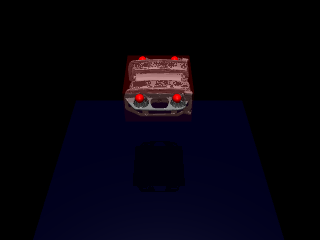

In [3]:
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [4]:
duration = 2  # (seconds)
framerate = 60  # (Hz)

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2

frames = []
mujoco.mj_resetData(model, data)
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    camera.lookat = data.body('body').subtree_com
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

# Simulate and display video.
media.show_video(frames, fps=framerate)

### Measuring values from `mjData`

Text(0, 0.5, 'm / s')

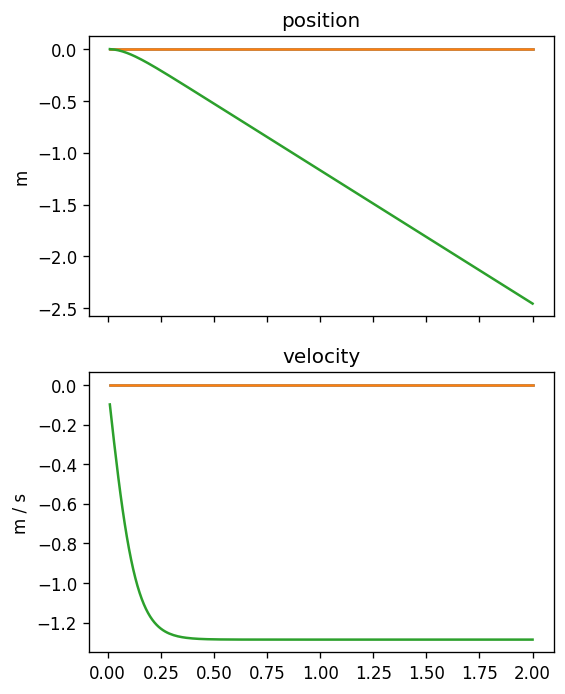

In [11]:
timevals = []
position = []
velocity = []

mujoco.mj_resetData(model, data)

# Simulate and save data
while data.time < duration:

  mujoco.mj_step(model, data)
  timevals.append(data.time)

  position.append(data.qpos[0:3].copy())
  velocity.append(data.qvel[0:3].copy())

dpi = 120
width = 600
height = 800
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi, sharex=True)

ax[0].plot(timevals, position)
ax[0].set_title('position')
ax[0].set_ylabel('m')

ax[1].plot(timevals, velocity)
ax[1].set_title('velocity')
ax[1].set_ylabel('m / s')

### Control torques

In [5]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

mujoco.mj_resetData(model, data)
model.opt.gravity = [0, 0, 0]
frames = []

while data.time < DURATION:
  # Set control vector.
  data.ctrl = np.random.randn(model.nu)

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:

    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

#### Inverse dynamics

In [13]:
model.opt.gravity = [0, 0, -9.81]
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)
data.qacc = 0  # Assert that there is no the acceleration.
mujoco.mj_inverse(model, data)
W = data.qfrc_inverse[2]
print(data.qfrc_inverse)

[  0.      0.    122.625   0.      0.      0.   ]


In [7]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Set the state and controls to their setpoints.
mujoco.mj_resetData(model, data)
# data.ctrl = -ctrl0
data.xfrc_applied[model.body('buoyancy').id][2] = W*1.01

frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:

    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

In [8]:
r = np.zeros((8, 3))
r[0] = [0.12, -0.113875, 0.]
r[1] = [0.12, 0.113875, 0.]
r[2] = [-0.12, -0.113875, 0.]
r[3] = [-0.12, 0.113875, 0.]
r[4] = [0.12, -0.21805, .083787]
r[5] = [0.12, 0.21805, .083787]
r[6] = [-0.12, -0.21805, .083787]
r[7] = [-0.12, 0.21805, .083787]

In [9]:
d = np.zeros((8, 3))
d[0] = [-0.7, 0.7, 0]
d[1] = [-0.7, -0.7, 0]
d[2] = [0.7, 0.7, 0]
d[3] = [0.7, -0.7, 0]
d[4] = [0, 0, -1.0]
d[5] = [0, 0, 1.0]
d[6] = [0, 0, -1.0]
d[7] = [0, 0, 1.0]

In [10]:
[np.cross(r[i], d[i]) for i in range(8)]

[array([-0.   , -0.   ,  0.004]),
 array([ 0.   , -0.   , -0.004]),
 array([-0.   ,  0.   , -0.004]),
 array([0.   , 0.   , 0.004]),
 array([0.218, 0.12 , 0.   ]),
 array([ 0.218, -0.12 ,  0.   ]),
 array([ 0.218, -0.12 ,  0.   ]),
 array([ 0.218,  0.12 , -0.   ])]

In [13]:
heavy_mapping = [[-0.7, -0.7, 0.7, 0.7, 0., 0., 0., 0.],
                 [0.7, -0.7, 0.7, -0.7, 0., 0., 0., 0.],
                 [0., 0., 0., 0., -1., 1., -1., 1.],
                 [0., 0., 0., 0., 0.218, 0.218, 0.218, 0.218],
                 [0., 0., 0., 0., 0.12, -0.12, -0.12, 0.12],
                 [0.004, -0.004, -0.004, 0.004, 0., 0., 0., 0.]]

heavy_inputs_inv = np.linalg.pinv(heavy_mapping)
heavy_inputs_inv.shape

(8, 6)

In [14]:
ctrl0 = heavy_inputs_inv @ data.qfrc_inverse
ctrl0 = ctrl0.flatten()  # Save the ctrl setpoint.
print('control setpoint:', ctrl0)

control setpoint: [  0.      0.      0.      0.    -30.656  30.656 -30.656  30.656]


In [15]:
data.ctrl = ctrl0
mujoco.mj_forward(model, data)
print('actuator forces:', data.qfrc_actuator)

actuator forces: [ -0.      0.    122.625  -0.      0.     -0.   ]


In [16]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Set the state and controls to their setpoints.
mujoco.mj_resetData(model, data)
data.ctrl = ctrl0

frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:

    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

### Manual control

In [17]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

mujoco.mj_resetData(model, data)
model.opt.viscosity = 0
model.opt.density = 0
model.opt.gravity = [0, 0, 0]
frames = []

while data.time < DURATION:
  # Set control vector.
  data.ctrl[:8] = - heavy_inputs_inv @ np.array([0, 0, 0, 0, 0, 1])

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:

    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

### Simple control

#### Model

In [4]:
from quat_routines import quaternion_product, quat2so3, quat2euler, conjugate, quat2rot, skew

def R(X):
  q = X[3:]
  return quat2rot(q).T

def T(X):
  q = X[3:]
  p, e1, e2, e3 = q
  return 0.5*np.array([[-e1, -e2, -e3],
                         [p, -e3, e2],
                         [e3, p, -e1],
                         [-e2, e1, p]])


def J(X):
    return np.block([[R(X), np.zeros((3,3))], [np.zeros((4,3)), T(X)]])

In [5]:
m = model.body('body').mass[0]
length, width, height = model.geom('box').size

# inertia for a box
I_0 = np.diag(model.body('body').inertia)

M_rb = np.block([[m*np.eye(3), np.zeros((3, 3))], [np.zeros((3, 3)), I_0]])

M = M_rb
M_inv = np.linalg.inv(M)

In [6]:
def C_rb(vel):
    v, w = vel[:3], vel[3:]
    return np.block([[m*skew(w), np.zeros((3, 3))], [np.zeros((3, 3)), -skew(I_0@w)]])

def C(v):
    return C_rb(v)

In [7]:
K_1 = np.diag([10, 10, 10, 0, 0, 0])  # коэффициенты взяты из головы
K_2 = np.diag([0.1, 0.1, 0.1, 0, 0, 0])  # коэффициенты взяты из головы

def D(vel):
    speed = np.linalg.norm(vel)

    D_lin = K_1
    D_quad = K_2*speed

    return D_lin + D_quad

In [8]:
r_b = model.body('buoyancy').pos

W = -m*(model.opt.gravity[-1])
B = W*1.0


def f_g(X):
  return -R(X).T@np.array([0, 0, W])

def f_b(X):
  return R(X).T@np.array([0, 0, B])

def g_(X):
    res = np.zeros((6, ))

    fg = f_g(X)
    fb = f_b(X)

    res[:3] = fg + fb
    res[3:] = np.cross(r_b, fb)
    return res

#### PID

In [9]:
from simple_pid import PID


def so3_error(quaternion, desired_quaternion):
    conjugated_quaternion = conjugate(quaternion)
    q_err = quaternion_product(desired_quaternion, conjugated_quaternion)
    so3_error = quat2so3(q_err)
    return so3_error


pids = [PID(1, 0.001, 0.0),
        PID(1, 0.001, 0.0),
        PID(1.2, 0.001, 0.0)]

p_gain = np.diag([3, 2, 5])
d_gain = np.diag([2, 1, 3])


def pd_torque(x, x_d, v):

    tau = []

    for i in range(3):
        tau.append(pids[i](x[i]))

    orientation_error = so3_error(x[3:], x_d[3:])
    omega = np.array(v[3:])
    body_torque = p_gain @ orientation_error - d_gain @ omega
    tau.extend(body_torque)

    return tau

In [10]:
L = 1


def model_based_pid(X, x_d):

    x, v = X[:7], X[7:]

    e_b = J(x).T@(np.array(x) - np.array(x_d))
    v_r = L*e_b
    a_r = -L*np.array(v)

    tau_m = M@a_r + g_(x)
    tau_pid = M@pd_torque(x, x_d, v)

    return tau_pid + tau_m

In [11]:
X_0 = [1, -1, -1.5, 0.9238795, 0, 0, 0.3826834,  1, 0, 0, 0, 0, 0]

X_d = [0.5, -0.7, -0.5, 1, 0, 0, 0]

for i in range(3):
    pids[i].reset()
    pids[i].setpoint = X_d[i]

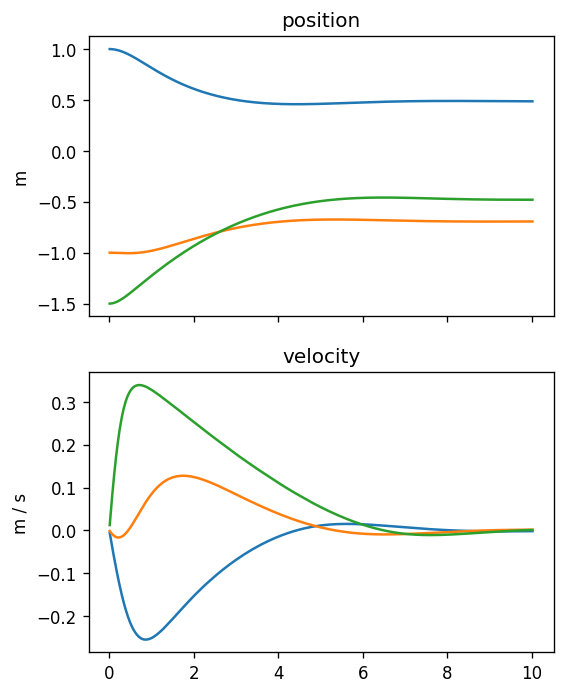

In [14]:
# Parameters.
DURATION = 10         # seconds
FRAMERATE = 60        # Hz

timevals = []
position = []
velocity = []

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)

# buonancy
data.xfrc_applied[model.body('buoyancy').id][2] = W*1.0

frames = []
step = 0

# # Allocate position difference dq.
# dq = np.zeros(model.nv)

data.qpos = X_0[:7]
x_d = X_d


while data.time < DURATION:
  # Get state difference dx.
  # mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos)
  # dx = np.hstack((dq, data.qvel)).T

  X = np.append(data.qpos, data.qvel, 0)

  # Control law.
  u = model_based_pid(X, x_d)
  # u[2], u[3] = u[3], u[2]

  data.ctrl = heavy_inputs_inv @ u

  # Step the simulation.
  mujoco.mj_step(model, data)

  timevals.append(data.time)
  position.append(data.qpos[0:3].copy())
  velocity.append(data.qvel[0:3].copy())

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

dpi = 120
width = 600
height = 800
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi, sharex=True)

ax[0].plot(timevals, position)
ax[0].set_title('position')
ax[0].set_ylabel('m')

ax[1].plot(timevals, velocity)
ax[1].set_title('velocity')
ax[1].set_ylabel('m / s')

plt.show()

media.show_video(frames, fps=FRAMERATE)